RAINSTORM

## Create models
- This notebook will train AI models to identify exploration using the mouse and object position, and the labels of the viewers.

#### Requirements:

- A set of position files
- Labeled data for the position files (to train the model)

or

- Access to the example file **colabels.csv**, where we can find:
    - Position and labels for representative exploration events
    - It includes the labels of 5 viewers (so far)

---
#### Load the necessary modules

In [1]:
import os
import pandas as pd
import datetime
import rainstorm.modeling as rst

rainstorm.create_models successfully imported. GPU devices detected: []


---
#### 1. State your project path & thresholds
`base` : The path to the downloaded repository. If you are using a Windows path with backslashes, place an ‘r’ in front of the directory path to avoid an error (e.g. r'C:\Users\dhers\Desktop\RAINSTORM').

`objects` : Name the stationary objects that appear on your data.

`bodyparts` : Name the bodyparts you want to use for training (to simplify the model, it is better to leave out the tail).

`labelers` : Names of the people that labeled the data (they should be the same as the columns in the `colabels` file).

`past` & `future` : If you use a LSTM model, you can set the window size by saying how many frames into the past and how many into the future you want to see.

`broad` : Once you have your window size, we can broaden the window by skipping some frames as we stray further from the present.

In [33]:
# State your path:
base = r'C:\Users\dhers\Desktop\RAINSTORM'
models_folder = os.path.join(base, r'docs\models')
colabels = os.path.join(models_folder, 'colabels.csv')

objects = ['obj']
bodyparts = ['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body']
labelers = ['Labeler_A', 'Labeler_B', 'Labeler_C', 'Labeler_D', 'Labeler_E']

past, future = 3, 3 # if you use a LSTM model, you can set the window size here
broad = 1.7 # using the same amount of frames, set how broad the window is (skipping frames)
broad_frames = rst.broaden(past, future, broad)
print(f'LSTM frame window: {broad_frames}')

use_saved_data = False # if True, we use a previous training-testing-validation split
if use_saved_data:
    saved_data = os.path.join(models_folder, 'splits/split_example_7w.h5') # Select the data you want to rescue

else:
    train_with_average = True # If False, it trains with all the labels separately
    make_discrete = False # If False, labels are float (not 0 and 1)
    save_data = True # if True, the data processed will be saved with today's date

# Get the start time
start_time = datetime.datetime.now()

LSTM frame window: [-6, -3, -1, 0, 1, 3, 6]


---
#### 3. Before training a model, we need to prepare our training data
- First, we load the dataset from the colabels file and create one 'labels' column out of all the labelers.
- Next (optional, but recommended) we can erase the rows of the dataset that are too far away from exploration events.
- Finally, we split the dataset into training, testing and validation subsets.

In [34]:
if use_saved_data:
    X_tr_wide, X_tr, y_tr, X_ts_wide, X_ts, y_ts, X_val_wide, X_val, y_val = rst.load_split(saved_data)

else:

    # Prepare the data
    dataset = rst.prepare_data(colabels, labelers) # This method of importing data should be improved

    # Focus on the rows near exploratory behaviour
    dataset = rst.focus(dataset, distance = 30)

    X_tr_wide, X_tr, y_tr, X_ts_wide, X_ts, y_ts, X_val_wide, X_val, y_val = rst.split_tr_ts_val(dataset, objects, bodyparts, past, future, broad)
    
    # Print the sizes of each set
    print(f"Training set size: {len(X_tr)} samples")
    print(f"Validation set size: {len(X_val)} samples")
    print(f"Testing set size: {len(X_ts)} samples")
    print(f"Total samples: {len(X_tr)+len(X_val)+len(X_ts)}")

    if save_data:
        rst.save_split(models_folder, start_time, X_tr_wide, X_tr, y_tr, X_ts_wide, X_ts, y_ts, X_val_wide, X_val, y_val)

Starting with 167012 rows
Reduced to 38370 rows. Number of exploration rows: 10471
Training set size: 27013 samples
Validation set size: 5727 samples
Testing set size: 5630 samples
Total samples: 38370
Saved data to split_2025-01-06_7w.h5


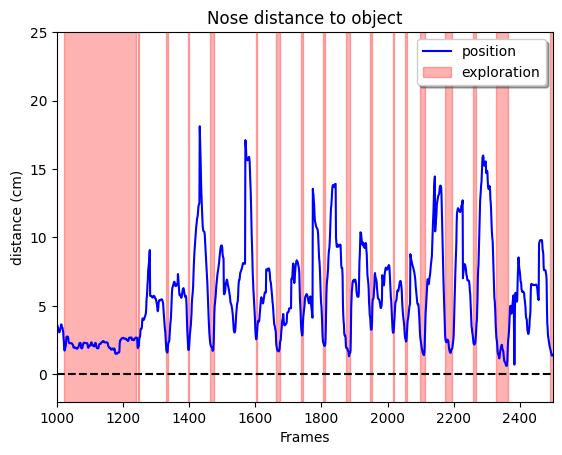

In [35]:
# We can see on the testing data that the exploratory events happen when the nose gets close to the object
rst.plot_example_data(X_ts, y_ts)

---
#### 4. With our training data ready, we can use TensorFlow to design our very first model
- It will look at the positions of one frame at a time, and try to decide if the mouse is exploring.
- If the decision is correct the architecture will be reinforced, else it will be corrected according to the learning rate.
- We will train it for some epochs (cycles through the whole dataset) and plot how the accuracy and loss evolve.
- Also, we will be validating the training using the validation split, which contains frames that were not used for training.

In [36]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

# Build a simple neural network
model_simple = tf.keras.Sequential([
    
    # Input layer
    Input(shape=(X_tr.shape[1],)), 

    # Hidden layers
    Dense(32, activation='relu'),
    Dense(24, activation='relu'),
    Dense(16, activation='relu'),
    Dense(12, activation='relu'),
    Dense(8, activation='relu'),
    
    # Output layer
    Dense(1, activation='sigmoid')
])

# Compile the model
model_simple.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), 
                   loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
model_simple.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 32)                416       
                                                                 
 dense_8 (Dense)             (None, 24)                792       
                                                                 
 dense_9 (Dense)             (None, 16)                400       
                                                                 
 dense_10 (Dense)            (None, 12)                204       
                                                                 
 dense_11 (Dense)            (None, 8)                 104       
                                                                 
 dense_12 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,925
Trainable params: 1,925
Non-traina

In [38]:
# Train the model
history_simple = model_simple.fit(X_tr, y_tr,
                                  epochs=10, # An epoch is a complete pass through the entire training dataset.
                                  batch_size=64, # The batch size is the number of training samples the model processes before updating its weights.
                                  validation_data=(X_val, y_val))

Epoch 1/10
423/423 [==============================] - 1s 2ms/step - loss: 0.5692 - accuracy: 0.5606 - val_loss: 0.4070 - val_accuracy: 0.6901
Epoch 2/10
423/423 [==============================] - 1s 1ms/step - loss: 0.3709 - accuracy: 0.6804 - val_loss: 0.3428 - val_accuracy: 0.7049
Epoch 3/10
423/423 [==============================] - 0s 1ms/step - loss: 0.3306 - accuracy: 0.7093 - val_loss: 0.3155 - val_accuracy: 0.7381
Epoch 4/10
423/423 [==============================] - 1s 1ms/step - loss: 0.3045 - accuracy: 0.7309 - val_loss: 0.2914 - val_accuracy: 0.7662
Epoch 5/10
423/423 [==============================] - 1s 1ms/step - loss: 0.2787 - accuracy: 0.7481 - val_loss: 0.2610 - val_accuracy: 0.7805
Epoch 6/10
423/423 [==============================] - 0s 1ms/step - loss: 0.2520 - accuracy: 0.7597 - val_loss: 0.2279 - val_accuracy: 0.7990
Epoch 7/10
423/423 [==============================] - 0s 1ms/step - loss: 0.2299 - accuracy: 0.7762 - val_loss: 0.2075 - val_accuracy: 0.8128
Epoch 

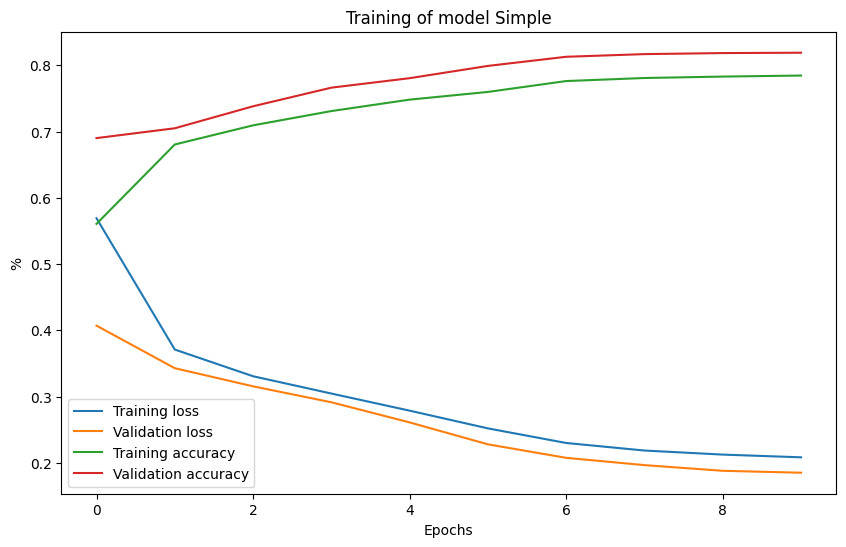

In [39]:
# Plot the training and validation loss
rst.plot_history(history_simple, "Simple")

In [40]:
y_pred_simple = model_simple.predict(X_ts)

# Calculate accuracy and precision of the model
accuracy_simple, precision_simple, recall_simple, f1_simple, mse_simple, mae_simple, r2_simple = rst.evaluate(y_pred_simple, y_ts, show_report = True)
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f}, MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")

176/176 [==============================] - 0s 600us/step
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4247
           1       0.86      0.81      0.83      1383

    accuracy                           0.92      5630
   macro avg       0.90      0.88      0.89      5630
weighted avg       0.92      0.92      0.92      5630

Accuracy = 0.9201, Precision = 0.9189, Recall = 0.9201, F1 Score = 0.9192, MSE = 0.0456, MAE = 0.1137, R-squared = 0.7431 -> simple


In [41]:
# Save the model
model_simple.save(os.path.join(models_folder, f'm_simple/simple_{start_time.date()}.keras'))

---
#### 5. Now that we have a simple model trained, we can start building more complex models with the help of some functions

To make our artificial networks as real as possible, we can let them see a sequence of frames to decide if the mouse is exploring.
- Our build_LSTM_model function will use Bidirectional LSTM layers that allow the model to take into account the sequence of frames.
- With `units` we can say how many and how big our hidden layers will be.
- We also implement an early stopping and learning rate scheduler mechanisms that will prevent the model from overfitting.


In [42]:
# Set the number of neurons in each layer
input_shape = (X_tr_wide.shape[1], X_tr_wide.shape[2])
units = [64, 32, 16, 8]

batch_size = 128 # Set the batch size
lr = 0.0001 # Set the initial learning rate
epochs = 60 # Set the training epochs

In [43]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, mode='min', verbose=1)

# Define a learning rate schedule function
def lr_schedule(epoch):
    warmup_epochs = 6  # Number of warm-up epochs
    initial_lr = 6e-5  # Starting learning rate
    peak_lr = 2e-4     # Peak learning rate
    decay_factor = 0.9 # Decay factor

    if epoch < warmup_epochs:
        # Exponential warm-up: increase learning rate exponentially
        return initial_lr * (peak_lr / initial_lr) ** (epoch / warmup_epochs)
    else:
        # Start decay after warm-up
        return peak_lr * (decay_factor ** (epoch - warmup_epochs))

# Define the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [44]:
# Build model
model_wide = rst.build_LSTM_model(input_shape, units)

# Compile model
model_wide.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), 
                   loss='binary_crossentropy', metrics=['accuracy'])

In [45]:
model_wide.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 7, 12)]           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 7, 128)           39424     
 nal)                                                            
                                                                 
 batch_normalization_4 (Batc  (None, 7, 128)           512       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 7, 128)            0         
                                                                 
 lambda_3 (Lambda)           (None, 5, 128)            0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 5, 64)            4121

In [46]:
# Train the model
history_wide = model_wide.fit(X_tr_wide, y_tr,
                              epochs = epochs,
                              batch_size = batch_size,
                              validation_data=(X_val_wide, y_val),
                              callbacks=[early_stopping, lr_scheduler])

Epoch 1/60
212/212 [==============================] - 12s 23ms/step - loss: 0.6765 - accuracy: 0.5353 - val_loss: 0.5454 - val_accuracy: 0.7882 - lr: 6.0000e-05
Epoch 2/60
212/212 [==============================] - 3s 16ms/step - loss: 0.5393 - accuracy: 0.6454 - val_loss: 0.3485 - val_accuracy: 0.7908 - lr: 7.3333e-05
Epoch 3/60
212/212 [==============================] - 3s 17ms/step - loss: 0.4763 - accuracy: 0.6969 - val_loss: 0.3286 - val_accuracy: 0.7969 - lr: 8.9628e-05
Epoch 4/60
212/212 [==============================] - 4s 17ms/step - loss: 0.4277 - accuracy: 0.7345 - val_loss: 0.3261 - val_accuracy: 0.8029 - lr: 1.0954e-04
Epoch 5/60
212/212 [==============================] - 4s 17ms/step - loss: 0.3888 - accuracy: 0.7571 - val_loss: 0.3109 - val_accuracy: 0.8093 - lr: 1.3389e-04
Epoch 6/60
212/212 [==============================] - 4s 17ms/step - loss: 0.3500 - accuracy: 0.7698 - val_loss: 0.3083 - val_accuracy: 0.8081 - lr: 1.6364e-04
Epoch 7/60
212/212 [===================

KeyboardInterrupt: 

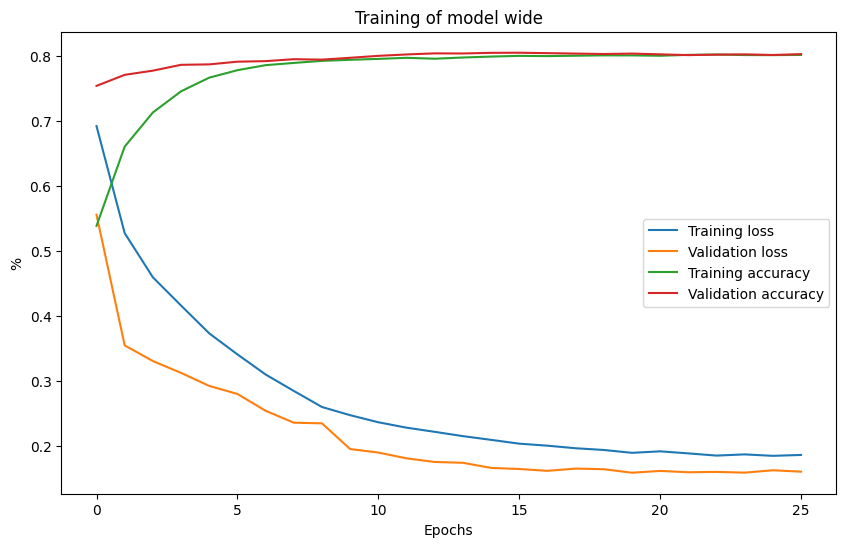

In [48]:
# Plot the training and validation loss
rst.plot_history(history_wide, "wide")

In [49]:
y_pred_wide = model_wide.predict(X_ts_wide)

# Calculate accuracy and precision of the model
accuracy_wide, precision_wide, recall_wide, f1_wide, mse_wide, mae_wide, r2_wide = rst.evaluate(y_pred_wide, y_ts, show_report=True)
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f}, MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")

176/176 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4247
           1       0.87      0.92      0.89      1383

    accuracy                           0.95      5630
   macro avg       0.92      0.94      0.93      5630
weighted avg       0.95      0.95      0.95      5630

Accuracy = 0.9467, Precision = 0.9479, Recall = 0.9467, F1 Score = 0.9471, MSE = 0.0305, MAE = 0.0739, R-squared = 0.8280 -> wide


In [50]:
# Save the model
model_wide.save(os.path.join(models_folder, f'm_wide/wide_{start_time.date()}_{X_ts_wide.shape[1]}w.keras'))

---
#### 6. Another method for classification using machine learning is creating a Random Forest model:

- Random Forest works by creating lots of decision trees during training.
- The output of the Random Forest in our case will be 1 or 0 (exploration or not) according to the decision of most trees.
- It is a very simple model to train.

In [51]:
from sklearn.ensemble import RandomForestClassifier
import joblib

In [52]:
# We train a RF model with the same data, but first we make it discrete
y_tr = (y_tr > 0.5).astype(int)

# Create the Random Forest model
RF_model = RandomForestClassifier(n_estimators = 24, max_depth = 12)

# Train the MultiOutputClassifier
RF_model.fit(X_tr, y_tr)

RandomForestClassifier(max_depth=12, n_estimators=24)

In [53]:
y_pred_RF = RF_model.predict(X_ts)

# Calculate accuracy and precision of the model
accuracy_RF, precision_RF, recall_RF, f1_RF, mse_RF, mae_RF, r2_RF = rst.evaluate(y_pred_RF, y_ts, show_report=True)
print(f"Accuracy = {accuracy_RF:.4f}, Precision = {precision_RF:.4f}, Recall = {recall_RF:.4f}, F1 Score = {f1_RF:.4f}, MSE = {mse_RF:.4f}, MAE = {mae_RF:.4f}, R-squared = {r2_RF:.4f} -> RF")

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4247
           1       0.88      0.91      0.89      1383

    accuracy                           0.95      5630
   macro avg       0.93      0.93      0.93      5630
weighted avg       0.95      0.95      0.95      5630

Accuracy = 0.9471, Precision = 0.9477, Recall = 0.9471, F1 Score = 0.9473, MSE = 0.0442, MAE = 0.0576, R-squared = 0.7510 -> RF


In [54]:
# Save the model
joblib.dump(RF_model, os.path.join(models_folder, f'm_RF/RF_{start_time.date()}.pkl'))

['C:\\Users\\dhers\\Desktop\\RAINSTORM\\docs\\models\\m_RF/RF_2025-01-06.pkl']

---
#### 7. Finally, we can compare all the models we've trained

- Since we trained using the training dataset, and validated using the validation dataset... we test each model using the testing dataset.
- To compare each model with the performance of a human labeler, we shall meet again on the following notebook.

In [55]:
# Print the model results
print("Evaluate model vs testing data")

print("VS binary average")
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f} -> simple")
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f} -> wide")
print(f"Accuracy = {accuracy_RF:.4f}, Precision = {precision_RF:.4f}, Recall = {recall_RF:.4f}, F1 Score = {f1_RF:.4f} -> RF")

print("VS continuous average")
print(f"MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")
print(f"MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")
print(f"MSE = {mse_RF:.4f}, MAE = {mae_RF:.4f}, R-squared = {r2_RF:.4f} -> RF")

Evaluate model vs testing data
VS binary average
Accuracy = 0.9201, Precision = 0.9189, Recall = 0.9201, F1 Score = 0.9192 -> simple
Accuracy = 0.9467, Precision = 0.9479, Recall = 0.9467, F1 Score = 0.9471 -> wide
Accuracy = 0.9471, Precision = 0.9477, Recall = 0.9471, F1 Score = 0.9473 -> RF
VS continuous average
MSE = 0.0456, MAE = 0.1137, R-squared = 0.7431 -> simple
MSE = 0.0305, MAE = 0.0739, R-squared = 0.8280 -> wide
MSE = 0.0442, MAE = 0.0576, R-squared = 0.7510 -> RF


---
---
#### Our trained models are stored safely in our repository, with today's date.
We can:
- Continue on this notebook and evaluate the trained models
- Skip the evaluation and go use the models on our data in 4-Automatic_analysis.ipynb
---


## Evaluate models

I see you've decided to continue on this notebook! You wont regret it.

One may think that the evaluation we did on the testing set is enough, and in many cases it is. However, for our purpose of finding a model that resembles the labeling of an expert, we need to compare the performance of the model on all the manually labeled data we have. 

In [56]:
colabels_df = pd.read_csv(colabels)
position = colabels_df.filter(regex='_x|_y').filter(regex='^(?!.*tail)').copy() # Extract positions, excluding tail-related columns
manual_labels = pd.concat([colabels_df.filter(regex=name).copy() for name in labelers], axis=1) # Extract individual labelers' columns
geometric = colabels_df.filter(regex='Geometric').copy() # Extract geometric labels

use_model = '2025-01-06' # 'example' or a specific date, e.g. '2024-02-16'

---
#### 8. Calculate a good reference labeler
Since we want to compare the models and the labelers, we need to create a reference labeler.

This reference could be the mean of all the labelers, but then the labelers would have an unfair advantage.

To avoid this, we choose to simultaneously create a chimera labeler and a leave-one-out-mean:
- The chimera is created by randomly selecting a labeler on each row of the data.
- The leave-one-out-mean is created by averaging the remaining labelers.

This way, we can compare the chimera to the leave-one-out-mean knowing that they are independent.

In [57]:
# Create the chimera and the leave-one-out mean
chimera, loo_mean = rst.create_chimera_and_loo_mean(manual_labels, seed=42) 
loo_mean = rst.smooth_columns(loo_mean, columns=['loo_mean'])

# We can still calculate the mean of all the labelers and see how it compares to the leave-one-out mean
full_mean = pd.DataFrame(manual_labels.sum(axis=1)/manual_labels.shape[1], columns=["full_mean"])

---
#### 9. Load the models & use them to label exploration on all the available data

In [58]:
# Load the saved models
from keras.models import load_model
model_simple = load_model(os.path.join(models_folder, f'm_simple/simple_{use_model}.keras'))
model_wide = load_model(os.path.join(models_folder, f'm_wide/wide_{use_model}_{len(broad_frames)}w.keras'))

from joblib import load
RF_model = load(os.path.join(models_folder, f'm_RF/RF_{use_model}.pkl'))

In [59]:
X_all = position.copy()

all_RF = rst.use_model(X_all, RF_model, objects=['obj'])
all_wide = rst.use_model(X_all, model_wide, objects=['obj'], reshaping = True, past=past, future=future, broad=broad)
all_simple = rst.use_model(X_all, model_simple, objects=['obj'])

c:\Users\dhers\miniconda3\envs\rainstorm\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


5220/5220 [==============================] - 3s 617us/step


In [60]:
# We can create a dictionary containing all labelers to compare them with the loo mean
all_labelers = {'simple': all_simple, 'wide': all_wide, 'RF': all_RF,
                'chimera': chimera, 'mean': loo_mean, 'geometric': geometric,} # , 'full_mean': full_mean

# add the manual labels to the dictionary
for name in labelers:
    all_labelers[name] = colabels_df.filter(regex=name).copy()

# Verify the updated dictionary
print(all_labelers.keys())  # Check the keys to confirm the additions

dict_keys(['simple', 'wide', 'RF', 'chimera', 'mean', 'geometric', 'Labeler_A', 'Labeler_B', 'Labeler_C', 'Labeler_D', 'Labeler_E'])


---
#### 10. With all the labels organized, we can evaulate the performance of each

In [61]:
for name, pred in all_labelers.items():
    accuracy, precision, recall, f1, mse, mae, r2 = rst.evaluate(pred, loo_mean)
    print(f"Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, MSE = {mse:.4f}, MAE = {mae:.4f}, R-squared = {r2:.4f} -> {name}")

Accuracy = 0.9794, Precision = 0.9794, Recall = 0.9794, F1 Score = 0.9794, MSE = 0.0112, MAE = 0.0286, R-squared = 0.7873 -> simple
Accuracy = 0.9858, Precision = 0.9859, Recall = 0.9858, F1 Score = 0.9858, MSE = 0.0074, MAE = 0.0281, R-squared = 0.8594 -> wide
Accuracy = 0.9859, Precision = 0.9863, Recall = 0.9859, F1 Score = 0.9861, MSE = 0.0115, MAE = 0.0176, R-squared = 0.7827 -> RF
Accuracy = 0.9781, Precision = 0.9795, Recall = 0.9781, F1 Score = 0.9786, MSE = 0.0177, MAE = 0.0239, R-squared = 0.6645 -> chimera
Accuracy = 1.0000, Precision = 1.0000, Recall = 1.0000, F1 Score = 1.0000, MSE = 0.0000, MAE = 0.0000, R-squared = 1.0000 -> mean
Accuracy = 0.9746, Precision = 0.9732, Recall = 0.9746, F1 Score = 0.9726, MSE = 0.0231, MAE = 0.0293, R-squared = 0.5628 -> geometric
Accuracy = 0.9800, Precision = 0.9846, Recall = 0.9800, F1 Score = 0.9812, MSE = 0.0126, MAE = 0.0188, R-squared = 0.7613 -> Labeler_A
Accuracy = 0.9801, Precision = 0.9802, Recall = 0.9801, F1 Score = 0.9783, MS

We can visualize the similarity between labelers using a cosine similarity plot

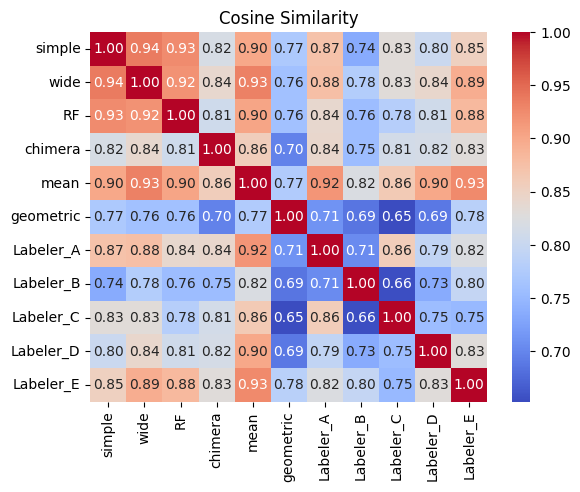

In [62]:
cosine_sim = rst.calculate_cosine_sim(all_labelers)

And finally, run a PCA (Principal Components Analysis) to see how much each labeler resembles eachother and the mean

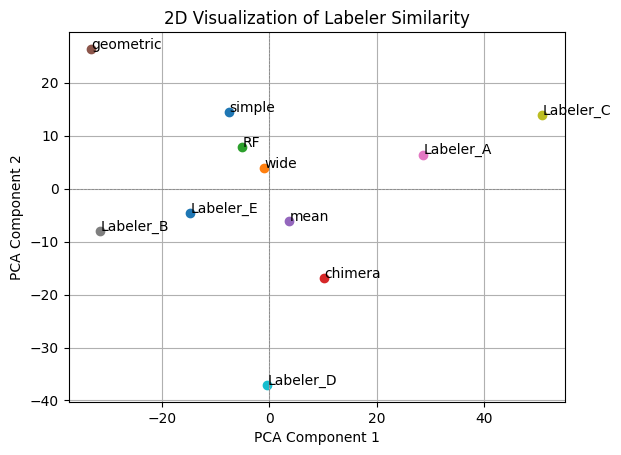

In [63]:
rst.plot_PCA(all_labelers)

Also, we can see both the models and the labelers performance on an example video

In [64]:
example_path = os.path.join(base, r'docs\examples\colabeled_video')

labelers_example = {
    "lblr_A": "Example_Marian.csv",
    "lblr_B": "Example_Agus.csv",
    "lblr_C": "Example_Santi.csv",
    "lblr_D": "Example_Guille.csv",
    "lblr_E": "Example_Myself.csv"
}

models = {
    "RF": (RF_model, {}),
    "Wide": (model_wide, {"reshaping": True}),
    "Simple": (model_simple, {}),
}

rst.plot_performance_on_video(example_path, models, labelers_example, plot_obj="obj_2")

c:\Users\dhers\miniconda3\envs\rainstorm\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


469/469 [==============================] - 0s 500us/step


---
---
#### Once we get to this point, we should have selected our favorite model.
We can move on to the next notebook and use the chosen model to label our files, 4-Automatic_analysis.ipynb

---
RAINSTORM - Created on Dec 12, 2023 - @author: Santiago D'hers